# MadMiner tutorial 1: From cards to likelihood ratios (parton level)

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In this tutorial we'll introduce the basic MadMiner workflow, using parton-level samples with simple smearing functions. We'll show you how to use MadMiner to generate events, extract training data, and train neural networks to estimate likelihood ratios.

This tutorial does not try to explain the inference methods. To understand what MadMiner is doing, please have a look at some papers first. In
["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013)
we explain the basic idea of most of the methods presented here, while ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020) is an extensive 65-page handbook going through the details.

## Preparations

Before you execute this notebook, make sure you have running installations of MadGraph, Pythia, and Delphes.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.core import MadMiner
from madminer.lhe import LHEProcessor
from madminer.sampling import combine_and_shuffle
from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas, random_morphing_thetas
from madminer.ml import MLForge
from madminer.plotting import plot_2d_morphing_basis, plot_distributions


Please enter here the path to your MG5 root directory.

In [2]:
mg_dir = '/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2'

MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [3]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## Input data

As an example process, we'll simulate VBF Higgs production with a decay into two photons. We'll try to measure two EFT coefficients that affect this process.

Have a look at the `cards` folder. You'll find text files ("cards") that specify the process simulation in typical MadGraph convention.

## 1. Define parameter space

After creating a `MadMiner` instance, the first important step is the definition of the parameter space. Each model parameter is characterized by a name as well as the LHA block and ID.

If morphing is used, one also has to specify the maximal power with which the parameter contributes to the squared matrix element. For instance, a parameter that contributes only to one vertex, will typically have `morphing_max_power=2`, while a parameter that contributes to two vertices usually has `morphing_max_power=4`. Exceptions arise for instance when the interference effects between the SM and dimension-six operators are modelled, but the square of the dimension-six amplitude (subleading in 1/Lambda) is not taken into account, in which case `morphing_max_power=1`. The `parameter_range` argument defines the range of parameter values that are used for the automatic optimization of the morphing basis.

Finally, the parameter values theta used internally by MadMiner and the parameter values written to the param_card (or reweight_card) given to MadGraph do not have to be exactly the same. With the option `parm_card_transform`, the user can supply a one-parameter function that maps a parameter value theta to the value given to MadGraph. This string is a python expression, in which `theta` is parsed as the parameter value. For instance, if the internal parameters are in the range (0, 1), but should be linearly scaled to (0, 100) in the param_card, one would have to use `param_card_transform="100*theta"`.

In [4]:
miner = MadMiner()

miner.add_parameter(
    lha_block='dim6',
    lha_id=2,
    parameter_name='CWL2',
    morphing_max_power=2,
    param_card_transform="16.52*theta",
    parameter_range=(-10.,10.)
)
miner.add_parameter(
    lha_block='dim6',
    lha_id=5,
    parameter_name='CPWL2',
    morphing_max_power=2,
    param_card_transform="16.52*theta",
    parameter_range=(-10.,1.0)
)

15:15 madminer.core        INFO    Added parameter CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-10.0, 10.0))
15:15 madminer.core        INFO    Added parameter CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-10.0, 1.0))


## 2. Define benchmark points (evaluation points for |M|^2)

The next step is the definition of all the points at which the weights (squared matrix elements) should be evaluated by MadGraph. We call these points "benchmarks".

### Set benchmarks by hand

One can define benchmarks by hand:

In [5]:
miner.add_benchmark(
    {'CWL2':0., 'CPWL2':0.},
    'sm'
)
miner.add_benchmark(
    {'CWL2':10., 'CPWL2':0.},
    'w'
)

15:15 madminer.core        INFO    Added benchmark sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00)
15:15 madminer.core        INFO    Added benchmark w: CWL2 = 10.00, CPWL2 = 0.00e+00)


### Morphing setup

If morphing is used, the function `set_morphing` has to be called. With the option `include_existing_benchmarks=True`, MadMiner will keep all the benchmark points defined beforehand and run a simple optimization algorithm to fix the remaining ones for the basis (which may be none). Otherwise, MadMiner will optimize the full basis and forget about all previously defined benchmark points.

The other important keyword is `max_overall_power`. This sets the maximal combined power with which all parameters together contribute to the squared matrix element (cross section). This constraint is in addition to the `morphing_max_power` keyword of `add_parameter()` (see above). For instance, if there are two parameters of interest `a` and `b`, and it is known that there are contributions proportional to `1` (constant), `a`, `a^2`, `b`, `b^2`, and `ab`, then `max_overall_power=2`. If there are also contributions proportional to `a^2 b`, `a b^2`, and `a^2 b^2`, then `max_overall_power=4`.

In [6]:
miner.set_morphing(
    include_existing_benchmarks=True,
    max_overall_power=2
)

15:15 madminer.core        INFO    Optimizing basis for morphing
15:15 madminer.core        INFO    Added benchmark sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00)
15:15 madminer.core        INFO    Added benchmark w: CWL2 = 10.00, CPWL2 = 0.00e+00)
15:15 madminer.core        INFO    Added benchmark morphing_basis_vector_2: CWL2 = -2.43e+00, CPWL2 = -9.92e+00)
15:15 madminer.core        INFO    Added benchmark morphing_basis_vector_3: CWL2 = -8.02e+00, CPWL2 = -5.62e+00)
15:15 madminer.core        INFO    Added benchmark morphing_basis_vector_4: CWL2 = -7.13e+00, CPWL2 = -1.36e+00)
15:15 madminer.core        INFO    Added benchmark morphing_basis_vector_5: CWL2 = 8.52, CPWL2 = -3.17e+00)


Let's have a look at the resulting morphing basis and the "morphing error", i.e. the sum of squared morphing weights as a function of the parameter space. The black dots mark the benchmarks at which the squared matrix element will be evaluated when MadGraph is run. In between them, the morphing will interpolate. Since the morphing knows about the functional form of the amplitudes, there is only a small numerical uncertainty in this interpolation, we expect that the color in this plot is indicative of this uncertainty.

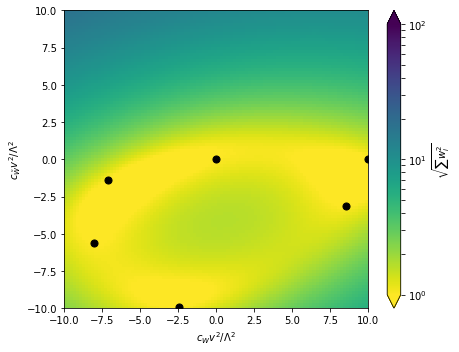

In [7]:
fig = plot_2d_morphing_basis(
    miner.morpher,
    xlabel=r'$c_{W} v^2 / \Lambda^2$',
    ylabel=r'$c_{\tilde{W}} v^2 / \Lambda^2$',
    xrange=(-10.,10.),
    yrange=(-10.,10.)
)

The parameter space, benchmark points, and morphing setup are saved in a HDF5 file:

In [8]:
miner.save('data/madminer_example.h5')

15:15 madminer.core        INFO    Saving setup (including morphing) to data/madminer_example.h5


They can now be loaded again with `miner.load(filename)`.

## 3. Save settings and run MadGraph

In a next step, MadMiner starts MadGraph to generate events and calculate the weights. You have to provide paths to the process card, run card, param card (the entries corresponding to the parameters of interest will be automatically adapted), and an empty reweight card. Log files in the `log_directory` folder collect the MadGraph output and are important for debugging.

The `sample_benchmark` option can be used to specify which benchmark should be used for sampling. If it is not used, MadMiner will automatically use the benchmark that was added first.

Finally, if your default Python interpreter is 3.x, you will want to use `python2_override=True` to force MadGraph to be started with Python 2.x.

In [9]:
miner.run(
    sample_benchmark='sm',
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/signal',
    proc_card_file='cards/proc_card_signal.dat',
    param_card_template_file='cards/param_card_template.dat',
    run_card_file='cards/run_card_signal.dat',
    log_directory='logs/signal',
    python2_override=True,
)

15:15 madminer.utils.inter INFO    Generating MadGraph process folder from cards/proc_card_signal.dat at ./mg_processes/signal
15:15 madminer.core        INFO    Run 0
15:15 madminer.core        INFO      Sampling from benchmark: sm
15:15 madminer.core        INFO      Original run card:       cards/run_card_signal.dat
15:15 madminer.core        INFO      Original Pythia8 card:   None
15:15 madminer.core        INFO      Copied run card:         /madminer/cards/run_card_0.dat
15:15 madminer.core        INFO      Copied Pythia8 card:     None
15:15 madminer.core        INFO      Param card:              /madminer/cards/param_card_0.dat
15:15 madminer.core        INFO      Reweight card:           /madminer/cards/reweight_card_0.dat
15:15 madminer.core        INFO      Log file:                run_0.log
15:15 madminer.core        INFO    Creating param and reweight cards in ./mg_processes/signal//madminer/cards/param_card_0.dat, ./mg_processes/signal//madminer/cards/reweight_card_0.dat
1

This will take a moment -- time for a coffee break!

After running any event generation through MadMiner, you should check whether the run succeeded: are the usual output files there (LHE and HepMC), do the log files show any error messages? MadMiner does not perform any explicit checks, and if something went wrong in the event generation, it will only notice later when trying to load the event files.

It is possible to start multiple processes based on the same `MadMiner` instance. This can be used to combine samples sampled according to different benchmarks, and to add reducible backgrounds. 

For the latter, a useful option is the `is_background` switch, which should be used for processes that do *not* depend on the parameters theta. `is_background=True` will disable the reweighting and re-use the same weights for all cross sections.

To reduce the runtime of the notebook, the background part is commented out here. Feel free to activate it and let it run during a lunch break.

In [10]:
"""
miner.run(
    is_background=True,
    sample_benchmark='sm',
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/background',
    proc_card_file='cards/proc_card_background.dat',
    param_card_template_file='cards/param_card_template.dat',
    run_card_file='cards/run_card_background.dat',
    log_directory='logs/background',
)
"""

u"\nminer.run(\n    is_background=True,\n    sample_benchmark='sm',\n    mg_directory=mg_dir,\n    mg_process_directory='./mg_processes/background',\n    proc_card_file='cards/proc_card_background.dat',\n    param_card_template_file='cards/param_card_template.dat',\n    run_card_file='cards/run_card_background.dat',\n    log_directory='logs/background',\n)\n"

Finally, two options might be very useful for larger projects:
- `MadMiner.run_multiple()` allows you to start multiple runs with different run cards or different choices of `sample_benchmark`.
- Both `MadMiner.run()` and `MadMiner.run_multiple()` have a `only_create_script` keyword. If that is set to True, MadMiner will not start the event generation directly, but prepare folders with all the right settings and ready-to-run bash scripts. This might make it much easier to generate Events on a high-performance computing system. 

## 4. Run smearing and extract observables

The `madminer.lhe` submodule allows us to extract observables directly from the parton-level LHE samples, including an approximate description of the detector response with smearing functions. The central object is an instance of the `LHEProcessor` class, which has to be initialized with a MadMiner file:

In [4]:
proc = LHEProcessor('data/madminer_example.h5')

After creating the LHEProcessor object, one can add a number of event samples (the output of running MadGraph in step 3) with the `add_sample()` function.

In addition, you have to provide the information which sample was generated from which benchmark with the `sampled_from_benchmark` keyword, and set `is_background=True` for all background samples.

In [5]:
proc.add_sample(
    lhe_filename='mg_processes/signal/Events/run_01/unweighted_events.lhe.gz',
    sampled_from_benchmark='sm',
    is_background=False,
    k_factor=1.1,
)

"""
proc.add_sample(
    lhe_filename='mg_processes/background/Events/run_01/unweighted_events.lhe.gz',
    sampled_from_benchmark='sm',
    is_background=True,
    k_factor=1.0,
"""


u"\nproc.add_sample(\n    lhe_filename='mg_processes/background/Events/run_01/unweighted_events.lhe.gz',\n    sampled_from_benchmark='sm',\n    is_background=True,\n    k_factor=1.0,\n"

Now we have to define the smearing functions that are used (in lieu of a proper shower and detector simulation). Here we will assume a simple 10% uncertainty on the jet energy measurements and a $\pm 0.1$ smearing for jet $\eta$ and $\phi$. The transverse momenta of the jets are then derived from the smeared energy and the on-shell condition for the quarks (this is what `pt_resolution_abs=None` does). The photons from the Higgs are assumed to be measured perfectly (otherwise we'd have to call `set_smearing` another time with `pdgis=[22]`).

In [6]:
proc.set_smearing(
    pdgids=[1,2,3,4,5,6,9,22,-1,-2,-3,-4,-5,-6],   # Partons giving rise to jets
    energy_resolution_abs=0.,
    energy_resolution_rel=0.1,
    pt_resolution_abs=None,
    pt_resolution_rel=None,
    eta_resolution_abs=0.1,
    eta_resolution_rel=0.,
    phi_resolution_abs=0.1,
    phi_resolution_rel=0.,
)

The next step is the definition of observables, either through a Python function or an expression that can be evaluated. Here we demonstrate the latter, which is implemented in `add_observable()`. In the expression string, you can use the terms `j[i]`, `e[i]`, `mu[i]`, `a[i]`, `met`, where the indices `i` refer to a ordering by the transverse momentum. In addition, you can use `p[i]`, which denotes the `i`-th particle in the order given in the LHE sample (which is the order in which the final-state particles where defined in MadGraph).

All of these represent objects inheriting from scikit-hep [LorentzVectors](http://scikit-hep.org/api/math.html#vector-classes), see the link for a documentation of their properties. In addition, they have `charge` and `pdg_id` properties.

`add_observable()` has an optional keyword `required`. If `required=True`, we will only keep events where the observable can be parsed, i.e. all involved particles have been detected. If `required=False`, un-parseable observables will be filled with the value of another keyword `default`.

In a realistic project, you would want to add a large number of observables that capture all information in your events. Here we will just define two observables, the transverse momentum of the leading (= higher-pT) jet, and the azimuthal angle between the two leading jets.

In [7]:
proc.add_observable(
    'pt_j1',
    'j[0].pt',
    required=False,
    default=0.,
)
proc.add_observable(
    'delta_phi_jj',
    'j[0].deltaphi(j[1]) * (-1. + 2.*float(j[0].eta > j[1].eta))',
    required=True,
)
proc.add_observable(
    'met',
    'met.pt',
    required=True,
)

We can also add cuts, again in parse-able strings. In addition to the objects discussed above, they can contain the observables:

In [8]:
proc.add_cut('(a[0] + a[1]).m > 124.')
proc.add_cut('(a[0] + a[1]).m < 126.')
proc.add_cut('pt_j1 > 30.')

The function `analyse_samples` then calculates all observables from the LHE file(s) generated before, applies the smearing, and checks which events pass the cuts:

In [10]:
proc.analyse_samples()

10:37 madminer.lhe         INFO    Analysing LHE sample mg_processes/signal/Events/run_01/unweighted_events.lhe.gz
10:39 madminer.utils.inter INFO      6461 events pass all cuts


The values of the observables and the weights are then saved in the HDF5 file. It is possible to overwrite the same file, or to leave the original file intact and save all the data into a new file as follows:

In [11]:
proc.save('data/madminer_example_with_data2.h5')

### A look at distributions

Let's see what our MC run produced:

10:39 madminer.sampling    INFO    Loading data from data/madminer_example_with_data2.h5
10:39 madminer.sampling    INFO    Found 2 parameters
10:39 madminer.sampling    INFO    Did not find nuisance parameters
10:39 madminer.sampling    INFO    Found 6 benchmarks, of which 6 physical
10:39 madminer.sampling    INFO    Found 3 observables
10:39 madminer.sampling    INFO    Found 6461 events
10:39 madminer.sampling    INFO    Found morphing setup with 6 components


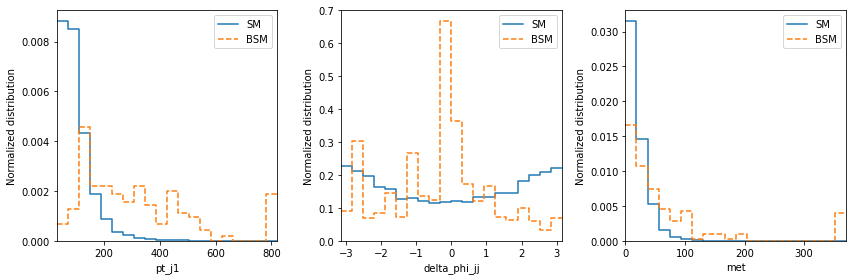

In [12]:
_ = plot_distributions(
    filename='data/madminer_example_with_data2.h5',
    parameter_points=['sm', np.array([10.,0.])],
    line_labels=['SM', 'BSM'],
    uncertainties='none',
    n_bins=20,
    n_cols=3,
    normalize=True,
)

## 5. Combine and shuffle different event samples

To reduce disk usage, you can generate several small event samples with the steps given above, and combine them now. Note that (for now) it is essential that all of them are generated with the same setup, including the same benchmark points / morphing basis!

In our case we only have one sample, so this is not strictly necessary, but we still include it for completeness.

In [19]:
combine_and_shuffle(
    ['data/madminer_example_with_data.h5'],
    'data/madminer_example_shuffled.h5'
)

16:24 madminer.sampling    INFO    Copying setup from data/madminer_example_with_data.h5 to data/madminer_example_shuffled.h5
16:24 madminer.sampling    INFO    Loading samples from file 1 / 1 at data/madminer_example_with_data.h5, multiplying weights with k factor 1.0


## 6. Make (unweighted) training and test samples with augmented data

At this point, we have all the information we need from MadGraph, Pythia, and Delphes. But the data is not quite ready to be used for machine learning. The `madminer.sampling` class `SampleAugmenter` will take care of the remaining book-keeping steps before we can train our estimators:

First, it unweights the samples, i.e. for a given parameter vector `theta` (or a distribution `p(theta)`) it picks events `x` such that their distribution follows `p(x|theta)`. The selected samples will all come from the event file we have so far, but their frequency is changed -- some events will appear multiple times, some will disappear.

Second, `SampleAugmenter` calculates all the augmented data ("gold") that is the key to our new inference methods. Depending on the specific technique, these are the joint likelihood ratio and / or the joint score. It saves all these pieces of information for the selected events in a set of numpy files that can easily be used in any machine learning framework.

In [4]:
sa = SampleAugmenter('data/madminer_example_shuffled.h5')

11:15 madminer.sampling    INFO    Loading data from data/madminer_example_shuffled.h5
11:15 madminer.sampling    INFO    Found 2 parameters
11:15 madminer.sampling    INFO    Did not find nuisance parameters
11:15 madminer.sampling    INFO    Found 6 benchmarks, of which 6 physical
11:15 madminer.sampling    INFO    Found 2 observables
11:15 madminer.sampling    INFO    Found 6537 events
11:15 madminer.sampling    INFO    Found morphing setup with 6 components


The `SampleAugmenter` class defines five different high-level functions to generate train or test samples:
- `extract_samples_train_plain()`, which only saves observations x, for instance for histograms or ABC;
- `extract_samples_train_local()` for methods like SALLY and SALLINO, which will be demonstrated in the second part of the tutorial;
- `extract_samples_train_ratio()` for techniques like CARL, ROLR, CASCAL, and RASCAL, when only theta0 is parameterized;
- `extract_samples_train_more_ratios()` for the same techniques, but with both theta0 and theta1 parameterized;
- `extract_samples_test()` for the evaluation of any method.

For the arguments `theta`, `theta0`, or `theta1`, you can (and should!) use the helper functions `constant_benchmark_theta()`, `multiple_benchmark_thetas()`, `constant_morphing_theta()`, `multiple_morphing_thetas()`, and `random_morphing_thetas()`, all defined in the `madminer.sampling` module.

Here we'll train a likelihood ratio estimator with the ALICES method, so we focus on the `extract_samples_train_ratio()` function.

In [5]:
x, theta0, theta1, y, r_xz, t_xz = sa.extract_samples_train_ratio(
    theta0=random_morphing_thetas(100, [('gaussian', 0., 10.), ('gaussian', 0., 10.)]),
    theta1=constant_benchmark_theta('sm'),
    n_samples=100000,
    folder='./data/samples',
    filename='train'
)

11:16 madminer.sampling    INFO    Extracting training sample for ratio-based methods. Numerator hypothesis: (u'random', (100, [(u'gaussian', 0.0, 10.0), (u'gaussian', 0.0, 10.0)])), denominator hypothesis: (u'benchmark', u'sm')
11:16 madminer.sampling    WARNING Large statistical uncertainty on the total cross section for theta = [ 5.47284667 14.76455978]: (0.001128 +/- 0.000867) pb. Skipping these warnings in the future...
11:16 madminer.sampling    INFO    Effective number of samples: mean 20.662253633414174, with individual thetas ranging from 6.473565084442877 to 215.8781933459663
11:16 madminer.sampling    INFO    Effective number of samples: mean 3269.0000000001205, with individual thetas ranging from 3269.0000000001205 to 3269.0000000001205


For the evaluation we'll need a test sample:

In [6]:
_ = sa.extract_samples_test(
    theta=constant_benchmark_theta('sm'),
    n_samples=100000,
    folder='./data/samples',
    filename='test'
)

11:16 madminer.sampling    INFO    Extracting evaluation sample. Sampling according to (u'benchmark', u'sm')
11:16 madminer.sampling    INFO    Effective number of samples: 3267.0000000001196


### Plot cross section over parameter space

We can also calculate total cross sections:

In [23]:
thetas_benchmarks, xsecs_benchmarks, xsec_errors_benchmarks = sa.extract_cross_sections(
    theta=multiple_benchmark_thetas(['sm', 'w', 'morphing_basis_vector_2', 'morphing_basis_vector_3', 'morphing_basis_vector_4', 'morphing_basis_vector_5'])
)

thetas_morphing, xsecs_morphing, xsec_errors_morphing = sa.extract_cross_sections(
    theta=random_morphing_thetas(1000, [('gaussian', 0., 4.), ('gaussian', 0., 4.)])
)

16:24 madminer.sampling    INFO    Starting cross-section calculation
16:24 madminer.sampling    INFO    Starting cross-section calculation


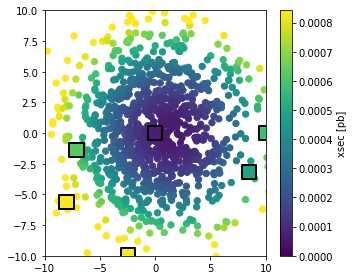

In [24]:
cmin, cmax = 0., 2.5 * np.mean(xsecs_morphing)

fig = plt.figure(figsize=(5,4))

sc = plt.scatter(thetas_morphing[:,0], thetas_morphing[:,1], c=xsecs_morphing,
            s=40., cmap='viridis', vmin=cmin, vmax=cmax,
            marker='o')

plt.scatter(thetas_benchmarks[:,0], thetas_benchmarks[:,1], c=xsecs_benchmarks,
            s=200., cmap='viridis', vmin=cmin, vmax=cmax, lw=2., edgecolor='black',
            marker='s')

cb = plt.colorbar(sc)
cb.set_label('xsec [pb]')

plt.xlim(-10.,10.)
plt.ylim(-10.,10.)
plt.tight_layout()
plt.show()

What  you see here is a morphing algorithm in action. We only asked MadGraph to calculate event weights (differential cross sections, or basically squared matrix elements) at six fixed parameter points (shown here as squares with black edges). But with our knowledge about the structure of the process we can interpolate any observable to any parameter point without loss (except that statistical uncertainties might increase)!

## 7. Train neural networks to estimate likelihood ratios

It's now time to build the neural network that estimates the likelihood ratio. The central object for this is the `madminer.ml.MLForge` class. It defines functions that train, save, load, and evaluate the estimators.

In [7]:
forge = MLForge()

### Training

We will use the ALICES technique described in ["Likelihood-free inference with an improved cross-entropy estimator"](https://arxiv.org/abs/1808.00973). Most other methods, including RASCAL, are described in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020). There is also SCANDAL introduced in ["Mining gold from implicit models to improve likelihood-free inference"](https://arxiv.org/abs/1805.12244).

Most of these methods exist both in a "single parameterized" version, in which only the dependence of the likelihood ratio on the numerator is modelled, and a "doubly parameterized" version, in which both the dependence on the numerator and denominator parameters is modelled. For the single parameterized version, use `method='rascal'`, `method='alice'`, and so on. For the double parameterized version, use `method='rascal2'`, `method='alice2'`, etc. Note that for the doubly parameterized estimators you have to provide `theta1_filename`, and in the case of RASCAL and ALICES also `t_xz1_filename`.

In [8]:
forge.train(
    method='alices',
    theta0_filename='data/samples/theta0_train.npy',
    x_filename='data/samples/x_train.npy',
    y_filename='data/samples/y_train.npy',
    r_xz_filename='data/samples/r_xz_train.npy',
    t_xz0_filename='data/samples/t_xz_train.npy',
    n_hidden=(20,20),
    alpha=10.,
    n_epochs=20,
    validation_split=0.3,
    batch_size=256
)

forge.save('models/alices')

11:16 madminer.ml          INFO    Starting training
11:16 madminer.ml          INFO      Method:                 alices
11:16 madminer.ml          INFO      Training data:          x at data/samples/x_train.npy
11:16 madminer.ml          INFO                              theta0 at data/samples/theta0_train.npy
11:16 madminer.ml          INFO                              y at data/samples/y_train.npy
11:16 madminer.ml          INFO                              r_xz at data/samples/r_xz_train.npy
11:16 madminer.ml          INFO                              t_xz (theta0) at data/samples/t_xz_train.npy
11:16 madminer.ml          INFO      Features:               all
11:16 madminer.ml          INFO      Method:                 alices
11:16 madminer.ml          INFO      Hidden layers:          (20, 20)
11:16 madminer.ml          INFO      Activation function:    tanh
11:16 madminer.ml          INFO      alpha:                  10.0
11:16 madminer.ml          INFO      Batch size:          

TypeError: super() argument 1 must be type, not classobj

### Evaluation

`forge.evaluate(theta,x)` estimated the log likelihood ratio and the score for all combination between the given phase-space points `x` and parameters `theta`. That is, if given 100 events `x` and a grid of 25 `theta` points, it will return 25\*100 estimates for the log likelihood and 25\*100 estimates for the  score, both indexed by `[i_theta,i_x]`.

In [27]:
theta_each = np.linspace(-20.,20.,21)
theta0, theta1 = np.meshgrid(theta_each, theta_each)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T
np.save('data/samples/theta_grid.npy', theta_grid)

theta_denom = np.array([[0.,0.]])
np.save('data/samples/theta_ref.npy', theta_denom)


In [28]:
forge.load('models/alices')

log_r_hat, _, _ = forge.evaluate(
    theta0_filename='data/samples/theta_grid.npy',
    x='data/samples/x_test.npy',
    evaluate_score=False
)

Let's look at the result:

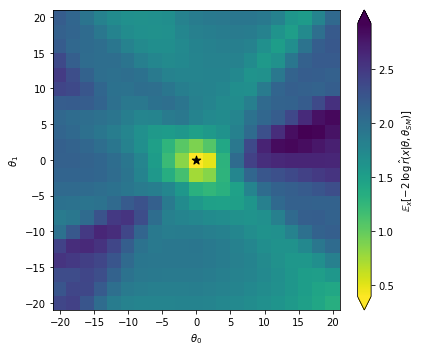

In [29]:
bin_size = theta_each[1] - theta_each[0]
edges = np.linspace(theta_each[0] - bin_size/2, theta_each[-1] + bin_size/2, len(theta_each)+1)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

expected_llr = np.mean(log_r_hat,axis=1)
best_fit = theta_grid[np.argmin(-2.*expected_llr)]

cmin, cmax = np.min(-2*expected_llr), np.max(-2*expected_llr)
    
pcm = ax.pcolormesh(edges, edges, -2. * expected_llr.reshape((21,21)),
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='*')

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label(r'$\mathbb{E}_x [ -2\, \log \,\hat{r}(x | \theta, \theta_{SM}) ]$')

plt.tight_layout()
plt.show()


Note that in this tutorial our sample size was very small, and the network does not really have a chance to converge to the correct likelihood ratio function. So don't worry if you find a minimum that is not at the right point (the SM, i.e. the origin in this plot). Feel free to dial up the event numbers in the run card as well as the training samples and see what happens then!

That's it for now. Please have a look at the documentation for a detailed description of all classes and functions. And if you're curious about SALLY, Fisher information matrices, and ensemble methods, please look at the second part of the tutorial!